# Mie Scattering Surrogate Model

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt

# tidy3d imports
import tidy3d as td
import tidy3d.web as web
import tidy3d.plugins.design as tdd

In [2]:
center = [0, 0, 0]

# permittivity of the sphere
epsr = 4

# Define material properties
air = td.Medium(permittivity=1)
diel = td.Medium(permittivity=epsr)

# resolution control
min_steps_per_wvl = 20

# define PML layers on all sides
boundary_spec = td.BoundarySpec.all_sides(boundary=td.PML())

# Simulation run time (s)
run_time = 2e-12

# Theta range for far-field
num_theta = 300
thetas = np.linspace(0, np.pi, num_theta)

In [3]:
def make_sim(radius):
    # free space central wavelength
    wavelength = 1.55
    f0 = td.C_0 / wavelength
    ldas = np.linspace(1.50, 1.60, 101)
    freqs = td.C_0 / ldas

    # distance between the surface of the sphere and the start of the PML layers along each cartesian direction
    buffer_PML = 3 * wavelength

    # distance between the sphere and the near field monitor along each cartesian direction
    buffer_mon = 1 * wavelength

    # distance between the sphere and the TFSF source region along each cartesian direction
    buffer_tfsf = 0.5 * wavelength

    # set the domain size in x, y, and z
    domain_size = buffer_PML + 2 * radius + buffer_PML

    # construct simulation size array
    sim_size = (domain_size, domain_size, domain_size)

    # create the sphere
    sphere = td.Structure(geometry=td.Sphere(center=center, radius=radius), medium=diel)
    geometry = [sphere]

    # Bandwidth in Hz
    fwidth = f0 / 10.0

    # time dependence of source
    gaussian = td.GaussianPulse(freq0=f0, fwidth=fwidth)

    # place the total-field region around the sphere, injecting a plane wave from the bottom in the +z direction
    source_size = [2 * radius + 2 * buffer_tfsf] * 3
    source = td.TFSF(
        center=center,
        size=source_size,
        source_time=gaussian,
        direction="+",
        pol_angle=0,
        injection_axis=2,
    )

    # set the far-field observation angles of interest
    # phis = np.linspace(0, np.pi / 2, num_phi)
    phi = 0 
    mon_size = 2 * radius + 2 * buffer_mon

    # create the far field monitor for server-side computation of far fields
    monitor_far = td.FieldProjectionAngleMonitor(
        center=center,
        size=[mon_size, mon_size, mon_size],
        freqs=freqs,
        name="far_field",
        custom_origin=center,
        phi=[phi],
        theta=list(thetas),
        far_field_approx=True,  # we leave this to its default value of 'True' because we are interested in fields sufficiently
        # far away that the far field approximations can be invoked to speed up the calculation
    )

    # create the phantom override structure for the mesh based on the TFSF source size
    mesh_override = td.Structure(
        geometry=td.Box(center=source.center, size=[i * 1.1 for i in source.size]),
        medium=diel,
    )
    grid_spec = td.GridSpec.auto(
        min_steps_per_wvl=min_steps_per_wvl, override_structures=[mesh_override]
    )

    # create the simulation object
    sim = td.Simulation(
        size=sim_size,
        grid_spec=grid_spec,
        structures=geometry,
        sources=[source],
        monitors=[monitor_far],
        run_time=run_time,
        boundary_spec=boundary_spec,
    )

    return sim

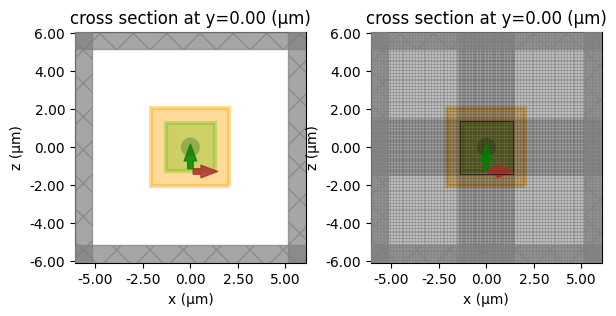

In [4]:
sim = make_sim(0.5)
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
sim.plot(y=0, ax=ax[0])
sim.plot(y=0, ax=ax[1])
sim.plot_grid(y=0, ax=ax[1])
plt.show()

In [5]:
def fn_post(sim_data):
    return sim_data["far_field"]

In [6]:
method = tdd.MethodMonteCarlo(
    num_points=100,
    seed=1,
)

r_param = tdd.ParameterFloat(name="radius", span=(0.5, 2.5))
parameters = [r_param]

output_dir = "/home/matt/Documents/Flexcompute/surrogate_data/mie/data"
design_space = tdd.DesignSpace(
    method=method,
    parameters=parameters,
    task_name="mie_1",
    folder_name="mieV1",
    path_dir=output_dir,
)


In [50]:
results = design_space.run(make_sim, fn_post, verbose=True)
df = results.to_dataframe()

11:55:38 BST Running 100 Simulations

11:55:41 BST ERROR: The name already exists.                                    

             ERROR: The name already exists.                                    

             ERROR: The name already exists.                                    

             ERROR: Suppressed 1 ERROR message.                                 

             ERROR: Suppressed 1 ERROR message.                                 

             ERROR: The name already exists.                                    

             ERROR: The name already exists.                                    

             ERROR: The name already exists.                                    

12:02:47 BST WARNING: Simulation final field decay value of 0.000935 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

12:02:48 BST WARNING: Simulation final field decay value of 0.0009 is greater   
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Simulation final field decay value of 0.00124 is greater  
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Simulation final field decay value of 0.000394 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

12:02:49 BST WARNING: Simulation final field decay value of 2.03e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

12:02:50 BST WARNING: Simulation final field decay value of 0.00169 is greater  
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Simulation final field decay value of 0.000389 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Simulation final field decay value of 0.000294 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

12:02:51 BST WARNING: Simulation final field decay value of 0.000349 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Simulation final field decay value of 0.000551 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

12:02:52 BST WARNING: Simulation final field decay value of 0.000926 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

12:02:53 BST WARNING: Simulation final field decay value of 0.000623 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Simulation final field decay value of 0.000571 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Simulation final field decay value of 0.000146 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

12:02:54 BST WARNING: Simulation final field decay value of 0.00107 is greater  
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Simulation final field decay value of 0.000321 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

12:02:55 BST WARNING: Simulation final field decay value of 0.000476 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

12:02:56 BST WARNING: Simulation final field decay value of 0.00102 is greater  
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Simulation final field decay value of 0.000907 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

12:02:57 BST WARNING: Simulation final field decay value of 0.000344 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Simulation final field decay value of 0.000498 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Simulation final field decay value of 0.0013 is greater   
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

12:02:58 BST WARNING: Simulation final field decay value of 0.00147 is greater  
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Simulation final field decay value of 0.000228 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

12:02:59 BST WARNING: Simulation final field decay value of 0.000741 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Simulation final field decay value of 0.000962 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

12:03:00 BST WARNING: Simulation final field decay value of 0.00117 is greater  
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

12:03:01 BST WARNING: Simulation final field decay value of 0.000329 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Simulation final field decay value of 0.000574 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Simulation final field decay value of 0.000879 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Simulation final field decay value of 0.00066 is greater  
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

12:03:02 BST WARNING: Simulation final field decay value of 0.000653 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Simulation final field decay value of 0.000734 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

12:03:03 BST WARNING: Simulation final field decay value of 0.000638 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Simulation final field decay value of 0.000715 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Simulation final field decay value of 0.000758 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Simulation final field decay value of 0.000337 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

12:03:04 BST WARNING: Simulation final field decay value of 8.47e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Simulation final field decay value of 0.00115 is greater  
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Simulation final field decay value of 0.000983 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

12:03:05 BST WARNING: Simulation final field decay value of 5.44e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Simulation final field decay value of 0.000253 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Simulation final field decay value of 0.00041 is greater  
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

12:03:06 BST WARNING: Simulation final field decay value of 0.000454 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Simulation final field decay value of 0.00179 is greater  
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Simulation final field decay value of 0.000834 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

12:03:07 BST WARNING: Simulation final field decay value of 7.48e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Simulation final field decay value of 0.000778 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

12:03:08 BST WARNING: Simulation final field decay value of 0.000976 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Simulation final field decay value of 0.000507 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Simulation final field decay value of 1.95e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

12:03:09 BST WARNING: Simulation final field decay value of 0.000647 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

12:03:10 BST WARNING: Simulation final field decay value of 0.00141 is greater  
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Simulation final field decay value of 0.000556 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

12:03:11 BST WARNING: Simulation final field decay value of 0.000834 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Simulation final field decay value of 1.91e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Simulation final field decay value of 0.000674 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Simulation final field decay value of 0.000717 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

In [7]:
# TESTING: Save off the df or load the df
import pickle
import os
os.chdir("/home/matt/Documents/Flexcompute/surrogate_data/mie/data")
# with open("result_100.pkl", "wb") as out_file:
#     pickle.dump(results, out_file)


with open("result_100.pkl", "rb") as in_file:
    results = pickle.load(in_file)

df = results.to_dataframe()

## Surrogate

In [27]:
expanded_df = df.copy()
expanded_df["rcs"] = expanded_df["output"].apply(lambda x: np.real(x.radar_cross_section).sel(phi=0, r=1e6))
expanded_df["rcs_by_f"] = expanded_df["rcs"].apply(lambda x: x.transpose("f", ...))
expanded_df.drop(["rcs", "output"], axis=1, inplace=True)
expanded_df = expanded_df.explode(["rcs_by_f"]).reset_index(drop=True)
expanded_df["freq"] = expanded_df["rcs_by_f"].apply(lambda x: float(x.f))
expanded_df["rcs_by_f"] = expanded_df["rcs_by_f"].apply(lambda x: x.values)

# Single value output
expanded_df["total_rcs"] = expanded_df["rcs_by_f"].apply(lambda x: x.sum())


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim

from tidy3d.plugins.design.surrogate_object import AI_Model

# Constants
output_dir = "/home/matt/Documents/Flexcompute/surrogate_data/mie"
data_dir = ["/home/matt/Documents/Flexcompute/surrogate_data/mie/data/"]

test_percentage = 0.20
valid_percentage = 0.20
batch_size = 256
epochs = 150

trial_count = 50

model = AI_Model(output_dir, data_dir, seed=2)

model.load_data_from_df(
    df=expanded_df,
    label_names=["total_rcs"],
    feature_names=["radius", "freq"],
    test_percentage=test_percentage,
    valid_percentage=valid_percentage,
    batch_size=batch_size,
    individual_feature_scaling=True,
    label_as_array=True
)

loss_fn = nn.MSELoss()

Using existing directory at pickle_data
Using existing directory at models
Using device cuda:0


In [29]:
# Define the model in PyTorch
class VariableANN(nn.Module):
    def __init__(self, input_size, neurons, dropout) -> None:
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, neurons[0]))

        for i in range(1, len(neurons)):
            self.layers.append(nn.Linear(neurons[i - 1], neurons[i]))

        self.layers.append(nn.Linear(neurons[-1], 1))

        self.drop = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.drop(self.relu(layer(x)))

        x = self.layers[-1](x)

        return x

Using existing directory at Model1


  0%|          | 0/100 [00:00<?, ?it/s]

Best State Updated. Epoch: 0
Best State Updated. Epoch: 1
Best State Updated. Epoch: 2


  4%|▍         | 4/100 [00:00<00:05, 17.83it/s]

Best State Updated. Epoch: 3


 10%|█         | 10/100 [00:00<00:02, 31.99it/s]

Best State Updated. Epoch: 4
Best State Updated. Epoch: 5
Best State Updated. Epoch: 6
Best State Updated. Epoch: 7
Best State Updated. Epoch: 8
Best State Updated. Epoch: 9
Best State Updated. Epoch: 10
Best State Updated. Epoch: 11
Best State Updated. Epoch: 12
Best State Updated. Epoch: 13


 20%|██        | 20/100 [00:00<00:02, 38.30it/s]

Best State Updated. Epoch: 14
Best State Updated. Epoch: 15
Best State Updated. Epoch: 16
Best State Updated. Epoch: 17
Best State Updated. Epoch: 18
Best State Updated. Epoch: 19
Best State Updated. Epoch: 20
Best State Updated. Epoch: 21
Best State Updated. Epoch: 22


 25%|██▌       | 25/100 [00:00<00:01, 41.22it/s]

Best State Updated. Epoch: 23
Best State Updated. Epoch: 24
Best State Updated. Epoch: 25
Best State Updated. Epoch: 26
Best State Updated. Epoch: 27


 36%|███▌      | 36/100 [00:01<00:01, 37.44it/s]

Best State Updated. Epoch: 28
Best State Updated. Epoch: 29
Best State Updated. Epoch: 30
Best State Updated. Epoch: 31
Best State Updated. Epoch: 32
Best State Updated. Epoch: 33
Best State Updated. Epoch: 34
Best State Updated. Epoch: 35
Best State Updated. Epoch: 36
Best State Updated. Epoch: 37


 46%|████▌     | 46/100 [00:01<00:01, 41.68it/s]

Best State Updated. Epoch: 38
Best State Updated. Epoch: 39
Best State Updated. Epoch: 40
Best State Updated. Epoch: 41
Best State Updated. Epoch: 42
Best State Updated. Epoch: 43
Best State Updated. Epoch: 44
Best State Updated. Epoch: 45
Best State Updated. Epoch: 46
Best State Updated. Epoch: 47


 51%|█████     | 51/100 [00:01<00:01, 43.05it/s]

Best State Updated. Epoch: 48
Best State Updated. Epoch: 49
Best State Updated. Epoch: 50
Best State Updated. Epoch: 51
Best State Updated. Epoch: 52


 62%|██████▏   | 62/100 [00:01<00:00, 39.71it/s]

Best State Updated. Epoch: 53
Best State Updated. Epoch: 54
Best State Updated. Epoch: 55
Best State Updated. Epoch: 56
Best State Updated. Epoch: 57
Best State Updated. Epoch: 58
Best State Updated. Epoch: 59
Best State Updated. Epoch: 60
Best State Updated. Epoch: 61
Best State Updated. Epoch: 62
Best State Updated. Epoch: 63


 72%|███████▏  | 72/100 [00:01<00:00, 43.91it/s]

Best State Updated. Epoch: 64
Best State Updated. Epoch: 65
Best State Updated. Epoch: 66
Best State Updated. Epoch: 67
Best State Updated. Epoch: 68
Best State Updated. Epoch: 69
Best State Updated. Epoch: 70
Best State Updated. Epoch: 71
Best State Updated. Epoch: 72
Best State Updated. Epoch: 73
Best State Updated. Epoch: 74


 78%|███████▊  | 78/100 [00:02<00:00, 36.65it/s]

Best State Updated. Epoch: 75
Best State Updated. Epoch: 76
Best State Updated. Epoch: 77
Best State Updated. Epoch: 78


 96%|█████████▌| 96/100 [00:02<00:00, 45.93it/s]

Best State Updated. Epoch: 85
Best State Updated. Epoch: 86
Best State Updated. Epoch: 92
Best State Updated. Epoch: 93
Best State Updated. Epoch: 94
Best State Updated. Epoch: 99


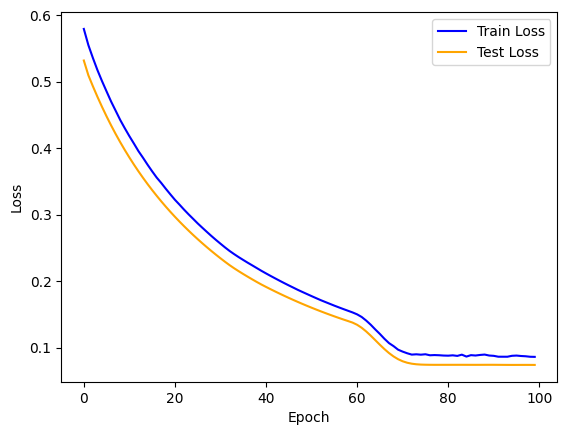

100%|██████████| 100/100 [00:02<00:00, 37.99it/s]

 Best Test Loss: 0.07408209145069122
RMSE: 16216.158833
MAE: 13031.016077


In [16]:
network = VariableANN(2, [4, 4, 4], 0.2)
opt = optim.Adam(network.parameters(), lr=0.001, weight_decay=0.0001)

trained_net = model.train_model("Model1", network, opt, loss_fn, 100, plot_output=True)
test_rmse, _, test_predictions = model.validate_model(trained_net, "test")


[I 2024-09-12 11:20:23,655] A new study created in memory with name: no-name-a9d11817-2da5-4328-a239-f7946e6bc785


Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:05<00:00, 29.08it/s]
[I 2024-09-12 11:20:28,839] Trial 0 finished with value: 8357.837929 and parameters: {'dropout': 0.2, 'neurons0': 32, 'neurons1': 160, 'neurons2': 128, 'neurons3': 128, 'lr': 0.00020957490791939475, 'weight_decay': 2.56623998836808e-05}. Best is trial 0 with value: 8357.837929.


 Best Test Loss: 0.015708450227975845
RMSE: 8357.837929
MAE: 5141.758146
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:05<00:00, 29.29it/s]
[I 2024-09-12 11:20:33,970] Trial 1 finished with value: 7412.384412 and parameters: {'dropout': 0.30000000000000004, 'neurons0': 96, 'neurons1': 96, 'neurons2': 160, 'neurons3': 160, 'lr': 3.453979704854047e-05, 'weight_decay': 0.00010645259250245113}. Best is trial 1 with value: 7412.384412.


 Best Test Loss: 0.01460820622742176
RMSE: 7412.384412
MAE: 5066.167924
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:05<00:00, 29.38it/s]
[I 2024-09-12 11:20:39,085] Trial 2 finished with value: 3589.435268 and parameters: {'dropout': 0.1, 'neurons0': 224, 'neurons1': 224, 'neurons2': 128, 'neurons3': 224, 'lr': 2.0824851253449582e-05, 'weight_decay': 0.0001024453334191056}. Best is trial 2 with value: 3589.435268.


 Best Test Loss: 0.003680275287479162
RMSE: 3589.435268
MAE: 2350.999894
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:04<00:00, 30.28it/s]
[I 2024-09-12 11:20:44,049] Trial 3 finished with value: 2893.887023 and parameters: {'dropout': 0.0, 'neurons0': 128, 'neurons1': 32, 'neurons2': 64, 'neurons3': 160, 'lr': 8.017666774803345e-05, 'weight_decay': 1.6364071508075995e-05}. Best is trial 3 with value: 2893.887023.


 Best Test Loss: 0.0023958194069564342
RMSE: 2893.887023
MAE: 1957.347991
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:05<00:00, 29.19it/s]
[I 2024-09-12 11:20:49,197] Trial 4 finished with value: 2867.650148 and parameters: {'dropout': 0.1, 'neurons0': 96, 'neurons1': 128, 'neurons2': 64, 'neurons3': 192, 'lr': 0.0008556168765786835, 'weight_decay': 0.00010244091290412624}. Best is trial 4 with value: 2867.650148.


 Best Test Loss: 0.0023079237435013056
RMSE: 2867.650148
MAE: 1981.654193
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:04<00:00, 30.20it/s]
[I 2024-09-12 11:20:54,172] Trial 5 finished with value: 16440.483326 and parameters: {'dropout': 0.2, 'neurons0': 224, 'neurons1': 160, 'neurons2': 64, 'neurons3': 192, 'lr': 0.0721446814835575, 'weight_decay': 0.00010000385053531142}. Best is trial 4 with value: 2867.650148.


 Best Test Loss: 0.006279031280428171
RMSE: 16440.483326
MAE: 14016.01707
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:05<00:00, 28.68it/s]
[I 2024-09-12 11:20:59,412] Trial 6 finished with value: 4007.142018 and parameters: {'dropout': 0.45, 'neurons0': 96, 'neurons1': 160, 'neurons2': 128, 'neurons3': 128, 'lr': 0.012771348031164653, 'weight_decay': 0.00011781710498405417}. Best is trial 4 with value: 2867.650148.


 Best Test Loss: 0.003678819164633751
RMSE: 4007.142018
MAE: 2841.309342
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:05<00:00, 29.14it/s]
[I 2024-09-12 11:21:04,568] Trial 7 finished with value: 7852.173867 and parameters: {'dropout': 0.5, 'neurons0': 160, 'neurons1': 32, 'neurons2': 96, 'neurons3': 224, 'lr': 0.00042179378105206954, 'weight_decay': 1.1334561723036805e-05}. Best is trial 4 with value: 2867.650148.


 Best Test Loss: 0.01517457328736782
RMSE: 7852.173867
MAE: 5066.839639
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:05<00:00, 28.42it/s]
[I 2024-09-12 11:21:09,855] Trial 8 finished with value: 3029.8451 and parameters: {'dropout': 0.1, 'neurons0': 32, 'neurons1': 256, 'neurons2': 256, 'neurons3': 224, 'lr': 0.0025542798985646654, 'weight_decay': 0.00033878152677157994}. Best is trial 4 with value: 2867.650148.


 Best Test Loss: 0.002628698479384184
RMSE: 3029.8451
MAE: 2089.451887
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:05<00:00, 28.99it/s]
[I 2024-09-12 11:21:15,038] Trial 9 finished with value: 3661.597806 and parameters: {'dropout': 0.05, 'neurons0': 96, 'neurons1': 160, 'neurons2': 96, 'neurons3': 32, 'lr': 0.08562760193073449, 'weight_decay': 7.633256192478052e-05}. Best is trial 4 with value: 2867.650148.


 Best Test Loss: 0.0033903277944773436
RMSE: 3661.597806
MAE: 2550.03924
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:04<00:00, 30.12it/s]
[I 2024-09-12 11:21:20,037] Trial 10 finished with value: 3784.677708 and parameters: {'dropout': 0.35000000000000003, 'neurons0': 160, 'neurons1': 96, 'neurons2': 32, 'neurons3': 64, 'lr': 0.0023435510642152513, 'weight_decay': 0.0007498580827111435}. Best is trial 4 with value: 2867.650148.


 Best Test Loss: 0.0036539386492222548
RMSE: 3784.677708
MAE: 2671.952766
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:04<00:00, 30.99it/s]
[I 2024-09-12 11:21:24,896] Trial 11 finished with value: 2866.442933 and parameters: {'dropout': 0.0, 'neurons0': 128, 'neurons1': 32, 'neurons2': 32, 'neurons3': 160, 'lr': 9.775111800102661e-05, 'weight_decay': 3.786765186441698e-05}. Best is trial 11 with value: 2866.442933.


 Best Test Loss: 0.002351293107494712
RMSE: 2866.442933
MAE: 1958.695315
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:04<00:00, 31.98it/s]
[I 2024-09-12 11:21:29,605] Trial 12 finished with value: 2774.102766 and parameters: {'dropout': 0.0, 'neurons0': 128, 'neurons1': 96, 'neurons2': 32, 'neurons3': 96, 'lr': 0.0007019658369026515, 'weight_decay': 3.773498229506798e-05}. Best is trial 12 with value: 2774.102766.


 Best Test Loss: 0.0022011548280715942
RMSE: 2774.102766
MAE: 1919.715588
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:04<00:00, 31.47it/s]
[I 2024-09-12 11:21:34,390] Trial 13 finished with value: 2826.429774 and parameters: {'dropout': 0.0, 'neurons0': 192, 'neurons1': 64, 'neurons2': 32, 'neurons3': 96, 'lr': 0.0001726212865802394, 'weight_decay': 3.7182030609792205e-05}. Best is trial 12 with value: 2774.102766.


 Best Test Loss: 0.0022860693279653788
RMSE: 2826.429774
MAE: 1907.266005
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:04<00:00, 30.34it/s]
[I 2024-09-12 11:21:39,353] Trial 14 finished with value: 2964.6793 and parameters: {'dropout': 0.2, 'neurons0': 256, 'neurons1': 96, 'neurons2': 192, 'neurons3': 96, 'lr': 0.006445980223422115, 'weight_decay': 4.1817931521847705e-05}. Best is trial 12 with value: 2774.102766.


 Best Test Loss: 0.0022546411491930485
RMSE: 2964.6793
MAE: 2040.460521
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:04<00:00, 31.64it/s]
[I 2024-09-12 11:21:44,112] Trial 15 finished with value: 2841.371972 and parameters: {'dropout': 0.0, 'neurons0': 192, 'neurons1': 64, 'neurons2': 32, 'neurons3': 64, 'lr': 0.00030668251916994804, 'weight_decay': 5.2408119004466726e-05}. Best is trial 12 with value: 2774.102766.


 Best Test Loss: 0.002311183139681816
RMSE: 2841.371972
MAE: 1937.084718
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:04<00:00, 30.17it/s]
[I 2024-09-12 11:21:49,103] Trial 16 finished with value: 3051.203638 and parameters: {'dropout': 0.15000000000000002, 'neurons0': 192, 'neurons1': 64, 'neurons2': 224, 'neurons3': 96, 'lr': 0.0009087001010896192, 'weight_decay': 0.00023438597443605904}. Best is trial 12 with value: 2774.102766.


 Best Test Loss: 0.0025081380736082792
RMSE: 3051.203638
MAE: 2143.747067
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:04<00:00, 31.07it/s]
[I 2024-09-12 11:21:53,951] Trial 17 finished with value: 5336.629577 and parameters: {'dropout': 0.35000000000000003, 'neurons0': 192, 'neurons1': 128, 'neurons2': 96, 'neurons3': 96, 'lr': 9.06951626309657e-05, 'weight_decay': 2.5484756645023392e-05}. Best is trial 12 with value: 2774.102766.


 Best Test Loss: 0.007416530512273312
RMSE: 5336.629577
MAE: 3494.398949
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:04<00:00, 31.87it/s]
[I 2024-09-12 11:21:58,676] Trial 18 finished with value: 5601.199363 and parameters: {'dropout': 0.0, 'neurons0': 256, 'neurons1': 64, 'neurons2': 32, 'neurons3': 32, 'lr': 1.153921656268612e-05, 'weight_decay': 2.2212742477674974e-05}. Best is trial 12 with value: 2774.102766.


 Best Test Loss: 0.008973615244030952
RMSE: 5601.199363
MAE: 4063.069774
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:04<00:00, 30.31it/s]
[I 2024-09-12 11:22:03,643] Trial 19 finished with value: 3218.1206 and parameters: {'dropout': 0.05, 'neurons0': 64, 'neurons1': 192, 'neurons2': 64, 'neurons3': 64, 'lr': 0.0023556223765202255, 'weight_decay': 0.00020621243748860299}. Best is trial 12 with value: 2774.102766.


 Best Test Loss: 0.002460882067680359
RMSE: 3218.1206
MAE: 2376.397063
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:04<00:00, 30.17it/s]
[I 2024-09-12 11:22:08,635] Trial 20 finished with value: 3988.253831 and parameters: {'dropout': 0.25, 'neurons0': 160, 'neurons1': 96, 'neurons2': 160, 'neurons3': 128, 'lr': 0.009262600160340435, 'weight_decay': 6.0766048663925876e-05}. Best is trial 12 with value: 2774.102766.


 Best Test Loss: 0.003304314101114869
RMSE: 3988.253831
MAE: 2735.877186
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:05<00:00, 29.93it/s]
[I 2024-09-12 11:22:13,667] Trial 21 finished with value: 2818.995972 and parameters: {'dropout': 0.05, 'neurons0': 192, 'neurons1': 64, 'neurons2': 32, 'neurons3': 64, 'lr': 0.00030393504922965244, 'weight_decay': 4.8318923039459564e-05}. Best is trial 12 with value: 2774.102766.


 Best Test Loss: 0.0022488331887871027
RMSE: 2818.995972
MAE: 1903.471903
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:04<00:00, 30.23it/s]
[I 2024-09-12 11:22:18,648] Trial 22 finished with value: 2808.075689 and parameters: {'dropout': 0.05, 'neurons0': 224, 'neurons1': 64, 'neurons2': 32, 'neurons3': 96, 'lr': 0.0004701846900307373, 'weight_decay': 3.510119965916949e-05}. Best is trial 12 with value: 2774.102766.


 Best Test Loss: 0.0021852566860616207
RMSE: 2808.075689
MAE: 1933.316154
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:04<00:00, 30.01it/s]
[I 2024-09-12 11:22:23,666] Trial 23 finished with value: 2659.810315 and parameters: {'dropout': 0.05, 'neurons0': 224, 'neurons1': 64, 'neurons2': 64, 'neurons3': 64, 'lr': 0.0004982620418340829, 'weight_decay': 1.607065013002349e-05}. Best is trial 23 with value: 2659.810315.


 Best Test Loss: 0.002019730396568775
RMSE: 2659.810315
MAE: 1794.039138
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:04<00:00, 30.53it/s]
[I 2024-09-12 11:22:28,598] Trial 24 finished with value: 2707.276131 and parameters: {'dropout': 0.15000000000000002, 'neurons0': 224, 'neurons1': 128, 'neurons2': 64, 'neurons3': 32, 'lr': 0.0006951275525392097, 'weight_decay': 1.0213288449044603e-05}. Best is trial 23 with value: 2659.810315.


 Best Test Loss: 0.0020783154759556055
RMSE: 2707.276131
MAE: 1874.733928
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:04<00:00, 30.27it/s]
[I 2024-09-12 11:22:33,573] Trial 25 finished with value: 2703.77077 and parameters: {'dropout': 0.15000000000000002, 'neurons0': 256, 'neurons1': 128, 'neurons2': 96, 'neurons3': 32, 'lr': 0.001379539677699615, 'weight_decay': 1.2183716812139891e-05}. Best is trial 23 with value: 2659.810315.


 Best Test Loss: 0.0019525985699146986
RMSE: 2703.77077
MAE: 1899.300141
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:04<00:00, 31.16it/s]
[I 2024-09-12 11:22:38,406] Trial 26 finished with value: 2586.360826 and parameters: {'dropout': 0.15000000000000002, 'neurons0': 256, 'neurons1': 128, 'neurons2': 96, 'neurons3': 32, 'lr': 0.0018918437290183746, 'weight_decay': 1.2213938397208414e-05}. Best is trial 26 with value: 2586.360826.


 Best Test Loss: 0.0018208957044407725
RMSE: 2586.360826
MAE: 1824.098881
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:04<00:00, 30.51it/s]
[I 2024-09-12 11:22:43,342] Trial 27 finished with value: 2971.189889 and parameters: {'dropout': 0.25, 'neurons0': 256, 'neurons1': 192, 'neurons2': 96, 'neurons3': 32, 'lr': 0.004642548748329148, 'weight_decay': 1.5354603757653375e-05}. Best is trial 26 with value: 2586.360826.


 Best Test Loss: 0.0022219617385417223
RMSE: 2971.189889
MAE: 2149.988538
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:04<00:00, 30.04it/s]
[I 2024-09-12 11:22:48,354] Trial 28 finished with value: 3806.223451 and parameters: {'dropout': 0.15000000000000002, 'neurons0': 256, 'neurons1': 192, 'neurons2': 96, 'neurons3': 32, 'lr': 0.027012231408045005, 'weight_decay': 1.605910500668306e-05}. Best is trial 26 with value: 2586.360826.


 Best Test Loss: 0.003011357272043824
RMSE: 3806.223451
MAE: 2706.318433
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:04<00:00, 30.14it/s]
[I 2024-09-12 11:22:53,350] Trial 29 finished with value: 2746.51395 and parameters: {'dropout': 0.15000000000000002, 'neurons0': 256, 'neurons1': 128, 'neurons2': 128, 'neurons3': 64, 'lr': 0.002113583195599507, 'weight_decay': 2.0987406808663444e-05}. Best is trial 26 with value: 2586.360826.


 Best Test Loss: 0.0017948384629562497
RMSE: 2746.51395
MAE: 1950.057484
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:05<00:00, 29.80it/s]
[I 2024-09-12 11:22:58,404] Trial 30 finished with value: 2692.398103 and parameters: {'dropout': 0.2, 'neurons0': 224, 'neurons1': 128, 'neurons2': 160, 'neurons3': 256, 'lr': 0.0017867768000609308, 'weight_decay': 1.2597183623992862e-05}. Best is trial 26 with value: 2586.360826.


 Best Test Loss: 0.001903305877931416
RMSE: 2692.398103
MAE: 1940.211675
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:05<00:00, 29.71it/s]
[I 2024-09-12 11:23:03,472] Trial 31 finished with value: 2854.798049 and parameters: {'dropout': 0.2, 'neurons0': 224, 'neurons1': 128, 'neurons2': 160, 'neurons3': 32, 'lr': 0.0012715115409607893, 'weight_decay': 1.2831934810712914e-05}. Best is trial 26 with value: 2586.360826.


 Best Test Loss: 0.002144764643162489
RMSE: 2854.798049
MAE: 2009.132158
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:04<00:00, 30.35it/s]
[I 2024-09-12 11:23:08,434] Trial 32 finished with value: 2703.34932 and parameters: {'dropout': 0.30000000000000004, 'neurons0': 224, 'neurons1': 96, 'neurons2': 192, 'neurons3': 64, 'lr': 0.0014468001682245825, 'weight_decay': 1.835440100414997e-05}. Best is trial 26 with value: 2586.360826.


 Best Test Loss: 0.0020910727325826883
RMSE: 2703.34932
MAE: 1851.489837
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:05<00:00, 29.95it/s]
[I 2024-09-12 11:23:13,462] Trial 33 finished with value: 2939.828011 and parameters: {'dropout': 0.30000000000000004, 'neurons0': 224, 'neurons1': 96, 'neurons2': 192, 'neurons3': 256, 'lr': 0.005583093855002191, 'weight_decay': 1.8513674154897238e-05}. Best is trial 26 with value: 2586.360826.


 Best Test Loss: 0.002432760549709201
RMSE: 2939.828011
MAE: 2021.64215
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:04<00:00, 30.32it/s]
[I 2024-09-12 11:23:18,429] Trial 34 finished with value: 3270.142083 and parameters: {'dropout': 0.30000000000000004, 'neurons0': 224, 'neurons1': 96, 'neurons2': 192, 'neurons3': 256, 'lr': 0.0001916098526995912, 'weight_decay': 2.8348633739545403e-05}. Best is trial 26 with value: 2586.360826.


 Best Test Loss: 0.002923977328464389
RMSE: 3270.142083
MAE: 2193.328796
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:05<00:00, 29.52it/s]
[I 2024-09-12 11:23:23,531] Trial 35 finished with value: 5633.210477 and parameters: {'dropout': 0.35000000000000003, 'neurons0': 256, 'neurons1': 96, 'neurons2': 160, 'neurons3': 128, 'lr': 0.015467458731590215, 'weight_decay': 1.4554607111101275e-05}. Best is trial 26 with value: 2586.360826.


 Best Test Loss: 0.008105789311230183
RMSE: 5633.210477
MAE: 3504.735081
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:05<00:00, 28.99it/s]
[I 2024-09-12 11:23:28,726] Trial 36 finished with value: 2801.623672 and parameters: {'dropout': 0.1, 'neurons0': 224, 'neurons1': 160, 'neurons2': 224, 'neurons3': 192, 'lr': 0.00407930480873476, 'weight_decay': 2.9225787502979503e-05}. Best is trial 26 with value: 2586.360826.


 Best Test Loss: 0.0017916008364409208
RMSE: 2801.623672
MAE: 2132.874733
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:05<00:00, 29.21it/s]
[I 2024-09-12 11:23:33,882] Trial 37 finished with value: 3026.670415 and parameters: {'dropout': 0.25, 'neurons0': 192, 'neurons1': 32, 'neurons2': 128, 'neurons3': 64, 'lr': 0.0014755420817011982, 'weight_decay': 1.0241067001482022e-05}. Best is trial 26 with value: 2586.360826.


 Best Test Loss: 0.0023028438445180655
RMSE: 3026.670415
MAE: 2325.822128
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:05<00:00, 28.31it/s]
[I 2024-09-12 11:23:39,204] Trial 38 finished with value: 3264.048747 and parameters: {'dropout': 0.1, 'neurons0': 224, 'neurons1': 128, 'neurons2': 224, 'neurons3': 192, 'lr': 5.168748729891427e-05, 'weight_decay': 1.933244877499328e-05}. Best is trial 26 with value: 2586.360826.


 Best Test Loss: 0.0030507941264659166
RMSE: 3264.048747
MAE: 2318.086532
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:05<00:00, 28.91it/s]
[I 2024-09-12 11:23:44,412] Trial 39 finished with value: 4175.339283 and parameters: {'dropout': 0.25, 'neurons0': 160, 'neurons1': 160, 'neurons2': 160, 'neurons3': 128, 'lr': 0.025349894963336082, 'weight_decay': 2.4875295219055627e-05}. Best is trial 26 with value: 2586.360826.


 Best Test Loss: 0.004307094030082226
RMSE: 4175.339283
MAE: 2857.104661
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:05<00:00, 29.05it/s]
[I 2024-09-12 11:23:49,596] Trial 40 finished with value: 2797.334132 and parameters: {'dropout': 0.2, 'neurons0': 256, 'neurons1': 224, 'neurons2': 192, 'neurons3': 160, 'lr': 0.0005262444939015089, 'weight_decay': 1.3642731845362846e-05}. Best is trial 26 with value: 2586.360826.


 Best Test Loss: 0.002217154484242201
RMSE: 2797.334132
MAE: 1905.057788
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:05<00:00, 29.03it/s]
[I 2024-09-12 11:23:54,785] Trial 41 finished with value: 2695.927712 and parameters: {'dropout': 0.2, 'neurons0': 256, 'neurons1': 128, 'neurons2': 128, 'neurons3': 32, 'lr': 0.0013151597735673673, 'weight_decay': 1.2128206805395032e-05}. Best is trial 26 with value: 2586.360826.


 Best Test Loss: 0.002002239227294922
RMSE: 2695.927712
MAE: 1891.08611
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:05<00:00, 28.77it/s]
[I 2024-09-12 11:24:00,019] Trial 42 finished with value: 2929.96618 and parameters: {'dropout': 0.4, 'neurons0': 224, 'neurons1': 128, 'neurons2': 128, 'neurons3': 64, 'lr': 0.0036308089950859235, 'weight_decay': 1.7636814685119603e-05}. Best is trial 26 with value: 2586.360826.


 Best Test Loss: 0.0023263089824467897
RMSE: 2929.96618
MAE: 1997.404898
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:05<00:00, 29.77it/s]
[I 2024-09-12 11:24:05,079] Trial 43 finished with value: 2522.517132 and parameters: {'dropout': 0.2, 'neurons0': 256, 'neurons1': 160, 'neurons2': 128, 'neurons3': 32, 'lr': 0.0016012956580089767, 'weight_decay': 1.2291844642237098e-05}. Best is trial 43 with value: 2522.517132.


 Best Test Loss: 0.0018211508868262172
RMSE: 2522.517132
MAE: 1752.234198
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:04<00:00, 30.37it/s]
[I 2024-09-12 11:24:10,039] Trial 44 finished with value: 2788.550357 and parameters: {'dropout': 0.2, 'neurons0': 256, 'neurons1': 160, 'neurons2': 128, 'neurons3': 32, 'lr': 0.0010253609382776504, 'weight_decay': 1.0094102631462128e-05}. Best is trial 43 with value: 2522.517132.


 Best Test Loss: 0.0020976585801690817
RMSE: 2788.550357
MAE: 1987.613381
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:05<00:00, 29.85it/s]
[I 2024-09-12 11:24:15,084] Trial 45 finished with value: 2484.03363 and parameters: {'dropout': 0.1, 'neurons0': 256, 'neurons1': 192, 'neurons2': 64, 'neurons3': 32, 'lr': 0.003231249487230234, 'weight_decay': 1.3058821276876875e-05}. Best is trial 45 with value: 2484.03363.


 Best Test Loss: 0.00175220868550241
RMSE: 2484.03363
MAE: 1727.307445
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:05<00:00, 29.37it/s]
[I 2024-09-12 11:24:20,212] Trial 46 finished with value: 2603.022909 and parameters: {'dropout': 0.1, 'neurons0': 256, 'neurons1': 224, 'neurons2': 64, 'neurons3': 32, 'lr': 0.0032803544978928104, 'weight_decay': 1.4004835118156118e-05}. Best is trial 45 with value: 2484.03363.


 Best Test Loss: 0.0019155932823196054
RMSE: 2603.022909
MAE: 1807.303177
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:05<00:00, 28.43it/s]
[I 2024-09-12 11:24:25,509] Trial 47 finished with value: 2549.478244 and parameters: {'dropout': 0.1, 'neurons0': 256, 'neurons1': 224, 'neurons2': 64, 'neurons3': 32, 'lr': 0.0031596193792945656, 'weight_decay': 1.4955840544968462e-05}. Best is trial 45 with value: 2484.03363.


 Best Test Loss: 0.0018611159175634384
RMSE: 2549.478244
MAE: 1714.199084
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:05<00:00, 29.06it/s]
[I 2024-09-12 11:24:30,691] Trial 48 finished with value: 2816.211323 and parameters: {'dropout': 0.1, 'neurons0': 256, 'neurons1': 224, 'neurons2': 64, 'neurons3': 32, 'lr': 0.003339668420702997, 'weight_decay': 2.2389187649326415e-05}. Best is trial 45 with value: 2484.03363.


 Best Test Loss: 0.0021990779787302017
RMSE: 2816.211323
MAE: 1907.708364
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:05<00:00, 29.22it/s]
[I 2024-09-12 11:24:35,845] Trial 49 finished with value: 3615.712755 and parameters: {'dropout': 0.1, 'neurons0': 256, 'neurons1': 256, 'neurons2': 64, 'neurons3': 32, 'lr': 0.009010069199782205, 'weight_decay': 0.0008234962562868041}. Best is trial 45 with value: 2484.03363.


 Best Test Loss: 0.003328419756144285
RMSE: 3615.712755
MAE: 2597.867908
Study statistics: 
  Number of finished trials:  50
  Number of pruned trials:  0
  Number of complete trials:  50
Best trial:
  Value:  2484.03363
  Params: 
    dropout: 0.1
    neurons0: 256
    neurons1: 192
    neurons2: 64
    neurons3: 32
    lr: 0.003231249487230234
    weight_decay: 1.3058821276876875e-05
Using existing directory at Model1


  0%|          | 4/10000 [00:00<05:18, 31.42it/s]

Best State Updated. Epoch: 0
Best State Updated. Epoch: 1
Best State Updated. Epoch: 3
Best State Updated. Epoch: 4
Best State Updated. Epoch: 5
Best State Updated. Epoch: 6


  0%|          | 12/10000 [00:00<05:25, 30.72it/s]

Best State Updated. Epoch: 7
Best State Updated. Epoch: 8
Best State Updated. Epoch: 9
Best State Updated. Epoch: 10
Best State Updated. Epoch: 11
Best State Updated. Epoch: 13


  0%|          | 20/10000 [00:00<05:23, 30.83it/s]

Best State Updated. Epoch: 17
Best State Updated. Epoch: 19


  0%|          | 24/10000 [00:00<05:21, 31.00it/s]

Best State Updated. Epoch: 20


  0%|          | 36/10000 [00:01<05:25, 30.59it/s]

Best State Updated. Epoch: 31
Best State Updated. Epoch: 33
Best State Updated. Epoch: 36


  1%|          | 59/10000 [00:02<05:57, 27.77it/s]

Best State Updated. Epoch: 52
Best State Updated. Epoch: 53


  1%|          | 67/10000 [00:02<05:37, 29.40it/s]

Best State Updated. Epoch: 63
Best State Updated. Epoch: 67


  1%|          | 79/10000 [00:02<05:30, 30.00it/s]

Best State Updated. Epoch: 75
Best State Updated. Epoch: 80
Best State Updated. Epoch: 81


  1%|          | 97/10000 [00:03<05:34, 29.63it/s]

Best State Updated. Epoch: 90


  1%|          | 112/10000 [00:03<06:13, 26.50it/s]

Best State Updated. Epoch: 108


  1%|▏         | 136/10000 [00:04<05:58, 27.50it/s]

Best State Updated. Epoch: 129
Best State Updated. Epoch: 130


  2%|▏         | 167/10000 [00:05<05:26, 30.10it/s]

Best State Updated. Epoch: 160


  2%|▏         | 178/10000 [00:06<05:48, 28.19it/s]

Best State Updated. Epoch: 173


  2%|▏         | 196/10000 [00:06<05:47, 28.25it/s]

Best State Updated. Epoch: 191
Best State Updated. Epoch: 192


  2%|▏         | 209/10000 [00:07<06:54, 23.63it/s]

Best State Updated. Epoch: 205


  2%|▏         | 222/10000 [00:07<06:11, 26.32it/s]

Best State Updated. Epoch: 216


  2%|▏         | 228/10000 [00:08<05:56, 27.43it/s]

Best State Updated. Epoch: 224


  2%|▏         | 246/10000 [00:08<05:36, 28.94it/s]

Best State Updated. Epoch: 240


  3%|▎         | 252/10000 [00:09<06:21, 25.52it/s]

Best State Updated. Epoch: 247


  3%|▎         | 283/10000 [00:10<07:18, 22.15it/s]

Best State Updated. Epoch: 281


  3%|▎         | 302/10000 [00:10<05:42, 28.33it/s]

Best State Updated. Epoch: 296


  3%|▎         | 311/10000 [00:11<05:49, 27.69it/s]

Best State Updated. Epoch: 305


  4%|▍         | 382/10000 [00:13<05:30, 29.13it/s]

Best State Updated. Epoch: 378


  4%|▍         | 394/10000 [00:14<05:24, 29.65it/s]

Best State Updated. Epoch: 390


  5%|▌         | 514/10000 [00:18<05:08, 30.74it/s]

Best State Updated. Epoch: 508


  5%|▌         | 546/10000 [00:19<05:17, 29.78it/s]

Best State Updated. Epoch: 539


  8%|▊         | 809/10000 [00:28<05:15, 29.17it/s]

Best State Updated. Epoch: 802
Best State Updated. Epoch: 808


 17%|█▋        | 1653/10000 [00:58<05:20, 26.04it/s]

Best State Updated. Epoch: 1648


 19%|█▉        | 1931/10000 [01:07<04:25, 30.38it/s]

Best State Updated. Epoch: 1926


 24%|██▍       | 2416/10000 [01:24<04:05, 30.95it/s]

Best State Updated. Epoch: 2411


100%|█████████▉| 9999/10000 [05:49<00:00, 28.77it/s]

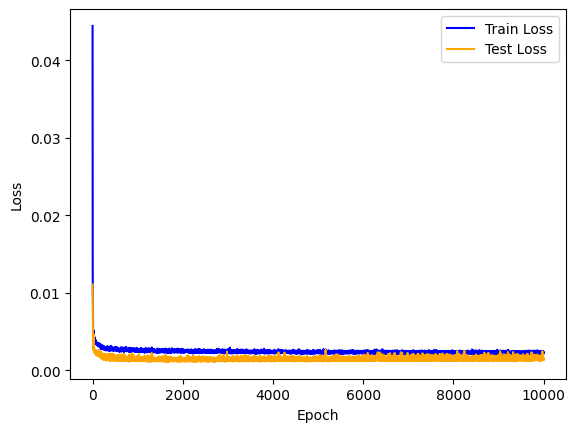

100%|██████████| 10000/10000 [05:49<00:00, 28.62it/s]

 Best Test Loss: 0.0010790990199893713


In [30]:
# Optimize model

network_dict = {
    "network": VariableANN,
    "kwargs": {"input_size": 2},
    "optimize_kwargs": {
        "dropout": {"name": "dropout", "low": 0.0, "high": 0.5, "step": 0.05},
        "neurons": {"name": "neurons", "low": 32, "high": 256, "step": 32, "multi": np.random.randint(3, 6)},
    },
}


optimizer_dict = {
    "optimizer": optim.Adam,
    "kwargs": {},
    "optimize_kwargs": {
        "lr": {"name": "lr", "low": 1e-5, "high": 1e-1, "log": True},
        "weight_decay": {"name": "weight_decay", "low": 1e-5, "high": 1e-3, "log": True},
    },
}

best_network, best_optimizer = model.optimize_network(
    trial_count, "minimize", network_dict, optimizer_dict, loss_fn, epochs
)

trained_net = model.train_model("Model1", best_network, best_optimizer, loss_fn, 10000, plot_output=True)

In [31]:
test_rmse, _, test_predictions = model.validate_model(trained_net, "test")
print(f"Mean: {model.test_labels.mean():.3f}, Percent Error: {test_rmse / model.test_labels.mean() * 100:.2f}")

RMSE: 2144.759527
MAE: 1599.713718
Mean: 19015.541, Percent Error: 11.28


In [ ]:
# Used for plotting full size spectra
index = 15
thetas = np.linspace(0, np.pi, num_theta)

test_rmse, _, test_predictions = model.validate_model(trained_net, "test")

def to_db(val):
    return 10.0 * np.log10(val)


fig, ax = plt.subplots(figsize=(7.5, 5))
ax.plot(thetas, to_db(model.test_labels[index]), "--g", label="Real")
ax.plot(thetas, to_db(test_predictions[index]), "--b", label="Predicted")
ax.set(
    xlabel="$\\theta$ (degrees)",
    ylabel="Bistatic RCS (dBs$\\mu$m)",
    yscale="linear",
    xscale="linear",
)
ax.grid(visible=True, which="both", axis="both", linewidth=0.4)
plt.legend(loc="best", prop={"size": 14})
plt.tight_layout()

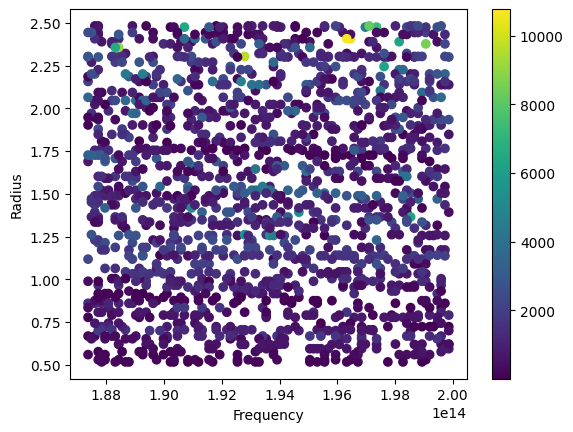

In [24]:
# Used for plotting radius and frequency for summed rcs
test_radii = model.feature_scaler[0].inverse_transform(model.test_loaded.dataset.x[:, 0].reshape(-1, 1))
test_freq = model.feature_scaler[1].inverse_transform(model.test_loaded.dataset.x[:, 1].reshape(-1, 1))
abs_dif = np.abs(model.test_labels - test_predictions)

predict_scatter = plt.scatter(test_freq, test_radii, c=abs_dif)
plt.xlabel("Frequency")
plt.ylabel("Radius")
plt.colorbar(predict_scatter)
plt.show()